In [1]:
import evaluation as eval
import helpers
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
import numpy as np
from datetime import timedelta
import evaluation

In [2]:
from pathlib import Path
def loadDataframes(baseDir):
    # bose_dir = "testAll/Bose/evaluation_results.csv"
    bose_dir = Path(baseDir,"Bose/evaluation_results.csv")
    b = helpers.readCSV_Lists(bose_dir)
    b["Algorithm/Options"] = b["Algorithm/Options"].apply(
        lambda x: 
        "Bose J" if x == "Bose Average J" 
        else "Bose WC" if x == "Bose Average WC" 
        else "Bose ???"
    )

    b_j = b[b["Algorithm/Options"] == "Bose J"]
    b_wc = b[b["Algorithm/Options"] == "Bose WC"]

    martjushev_dir = Path(baseDir,"Martjushev/evaluation_results.csv")
    m = helpers.readCSV_Lists(martjushev_dir)
    m["Algorithm/Options"] = m["Algorithm/Options"].apply(
        lambda x: 
        # "Martjushev J" if "Martjushev" in x and "J" in x
        # else "Martjushev WC" if "Martjushev" in x and "WC" in x
        # else "???"
        "Martjushev J" if x == "Martjushev Recursive Bisection; Average J; p=0.55"
        else "Martjushev WC" if x == "Martjushev Recursive Bisection; Average WC; p=0.55" 
        else "Martjushev ???"
    )
    m_j = m[m["Algorithm/Options"] == "Martjushev J"]
    m_wc = m[m["Algorithm/Options"] == "Martjushev WC"]

    em_dir = Path(baseDir,"Earthmover/evaluation_results.csv")
    em = helpers.readCSV_Lists(em_dir)

    prodrift_dir = Path(baseDir, "Maaradji/evaluation_results.csv")
    prodrift = helpers.readCSV_Lists(prodrift_dir)
    prodrift["Algorithm/Options"] = prodrift["Algorithm/Options"].apply(lambda x: "ProDrift")

    pgraph_dir = Path(baseDir, "ProcessGraph/evaluation_results.csv")
    pgraphs = helpers.readCSV_Lists(pgraph_dir)
    pgraphs["Algorithm/Options"] = pgraphs["Algorithm/Options"].apply(lambda x: "Process Graphs")

    zheng_dir = Path(baseDir, "Zheng/evaluation_results.csv")
    zheng = helpers.readCSV_Lists(zheng_dir)
    zheng["Algorithm/Options"] = zheng["Algorithm/Options"].apply(lambda x: "Zheng")

    dataframes = [b_j, b_wc, m_j, m_wc, prodrift, em, pgraphs, zheng]
    return dataframes

In [3]:
markers = {
    "Bose J": "^", # triangle_up
    "Bose WC": "^", # triangle_up
    "Martjushev J": "s", # square
    "Martjushev WC": "s", #square
}
colors = {
    "Bose J": "#add8e6", # Light Blue
    "Bose WC": "#000080", # Navy Blue
    "Martjushev J": "#32cd32", # Navy Green
    "Martjushev WC": "#006400", # Dark Green
    "ProDrift": "#ff0000", # Red
    "Earth Mover's Distance": "#ffa500", # Orange
    "Process Graphs": "#ddcd10", # Some dark, rich yellow
    "Zheng": "#800080" # Purple
    # The rest is just whatever it wants to give them
}

In [4]:
rocs = []
zhengDF = None
for df in loadDataframes("testAll"):
    roc_points = []
    name = df.iloc[-1]["Algorithm/Options"]
    if "zheng" in name.lower():
        zhengDF = df
        continue
    else:
        groups = df.groupby("Window Size")
    for _, group in groups:
        # Calculate average TPR and FPR 
        tpr = []
        fpr = []
        for i, row in group.iterrows():
            TPR, FPR = evaluation.calcTPR_FPR(lag=200, detected=row["Detected Changepoints"], known=row["Actual Changepoints for Log"], num_possible_negatives=3000-2)
            tpr.append(TPR)
            fpr.append(FPR)
        roc_points.append(
            (np.mean(tpr), np.mean(fpr))
        )
    rocs.append(
        (name, roc_points)
    )
# Zheng
roc_points = []
for mrid, g1 in zhengDF.groupby("MRID"):
    for epsilon, group in g1.groupby("Epsilon"):
        tpr = []
        fpr = []
        for i, row in group.iterrows():
            TPR, FPR = evaluation.calcTPR_FPR(lag=200, detected=row["Detected Changepoints"], known=row["Actual Changepoints for Log"], num_possible_negatives=3000-2)
            tpr.append(TPR)
            fpr.append(FPR)
        roc_points.append(
            (np.mean(tpr), np.mean(fpr))
        )
rocs.append(
    (name, roc_points)
)

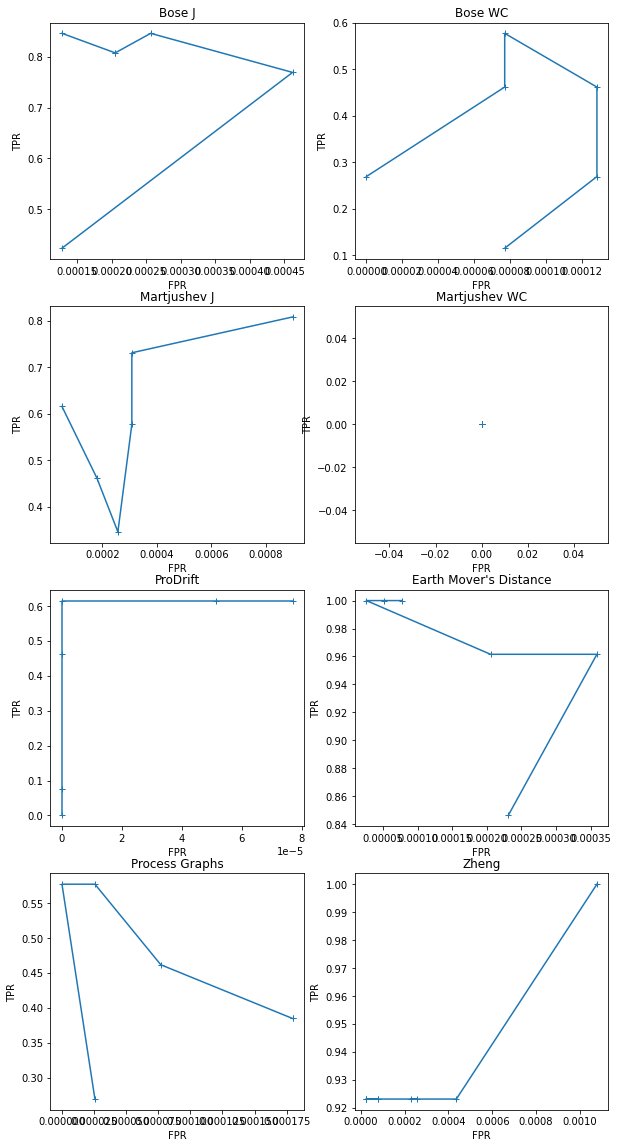

In [11]:
plt.rcParams["figure.figsize"] = (10,20)
figure, axis = plt.subplots(4, 2)
for i in range(4):
    for j in range(2):
        name, r = rocs[i*2+j]
# for name,r in rocs:
        fprs = [x[1] for x in r]
        tprs = [x[0] for x in r]

        axis[i,j].plot(fprs,tprs, "+-")
        axis[i,j].set_title(name)
        axis[i,j].set_ylabel("TPR")
        axis[i,j].set_xlabel("FPR")
# axis.axis("scaled")
plt.show()
# plt.savefig("roc_curves.pdf", format="pdf",bbox_inches='tight')